In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import glob
import utils
import matplotlib.colors as colors
import cmaps
from statsmodels.nonparametric.smoothers_lowess import lowess as  sm_lowess
from scipy.stats import pearsonr, t as tdist
from scipy.stats import t

In [2]:
def pvalue_array(x,y,dname):
    x_an=x-x.mean(dname)
    y_an=y-y.mean(dname)
    slope=(x_an*y_an).sum(dname)/(x_an*x_an).sum(dname)
    interc=y.mean(dname)-slope*x.mean(dname)
    ypred=slope*x+interc
    n=len(x[dname])
    mse=np.sqrt(((y-ypred)**2).sum(dname)/(n-2))
    xsq=np.sqrt(((x_an)**2).sum(dname))
    standerr=mse/xsq
    pval=2*(1-t.cdf(np.abs(slope/standerr),n-2))
    pval=xr.DataArray(pval,dims=standerr.dims,coords=standerr.coords)
    return pval

def rvalue_array(x,y,dname):
    xmean=x.mean(dname)
    ymean=y.mean(dname)
    numer=(x*y).mean(dname)-xmean*ymean
    denom=np.sqrt(((x**2).mean(dname)-xmean**2)*(((y**2).mean(dname))-(ymean**2)))
    return numer/denom

def regcoeff_array(x,y,dname):
    x_an=x-x.mean(dname)
    y_an=y-y.mean(dname)
    slope=(x_an*y_an).sum(dname)/(x_an*x_an).sum(dname)
    return slope

def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg, skipna=True)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

def trend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg, skipna=True)
    return p

def ann_mean(var):
    month_length = var.time.dt.days_in_month
    wgts = month_length.groupby("time.year") / month_length.groupby("time.year").sum()
    var_ann = (var*wgts).groupby("time.year").sum()
    return var_ann

In [12]:
datadir='/Projects/RAPrototype/ERA5'
plotdir='/home/ghervieux/SCRIPTS/GEV/PLOTS'

In [4]:
state_borders =\
cartopy.feature.NaturalEarthFeature(category='cultural',\
        name='admin_1_states_provinces_lakes', scale='50m', facecolor='none')

In [13]:

ifile = f'{datadir}/Jump_air.2m.nc' 
ds=xr.open_dataset(ifile)


In [27]:
ifile = f'/Projects/era5/Monthlies/monolevel/air.2m.mon.mean.nc' 
dsair=xr.open_dataset(ifile)
time = dsair['time']


In [15]:
print(ds['time_jump'].min(),ds['time_jump'].max())

<xarray.DataArray 'time_jump' ()> Size: 8B
array(5.) <xarray.DataArray 'time_jump' ()> Size: 8B
array(910.)


In [30]:
time_jump = ds['time_jump']
jump = ds['magnitude_jump']
units='$\degree$K'

<>:3: SyntaxWarning: invalid escape sequence '\d'
<>:3: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_1503769/2174613992.py:3: SyntaxWarning: invalid escape sequence '\d'
  units='$\degree$K'


In [34]:
np.where(np.isnan(time_jump)==False)

(array([  3,   3,   3, ..., 187, 187, 187], shape=(17940,)),
 array([ 93,  94,  95, ..., 396, 397, 398], shape=(17940,)))

In [37]:
time

<xarray.DataArray 'time' (time: 1026)> Size: 8kB
array(['1940-01-01T00:00:00.000000000', '1940-02-01T00:00:00.000000000',
       '1940-03-01T00:00:00.000000000', ..., '2025-04-01T00:00:00.000000000',
       '2025-05-01T00:00:00.000000000', '2025-06-01T00:00:00.000000000'],
      shape=(1026,), dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 8kB 1940-01-01 1940-02-01 ... 2025-06-01
Attributes:
    long_name:           Time
    standard_name:       time
    axis:                T
    delta_t:             0000-01-00 00:00:00
    coordinate_defines:  start
    actual_range:        [1227192. 1975944.]

Text(0.5, 0.98, '')

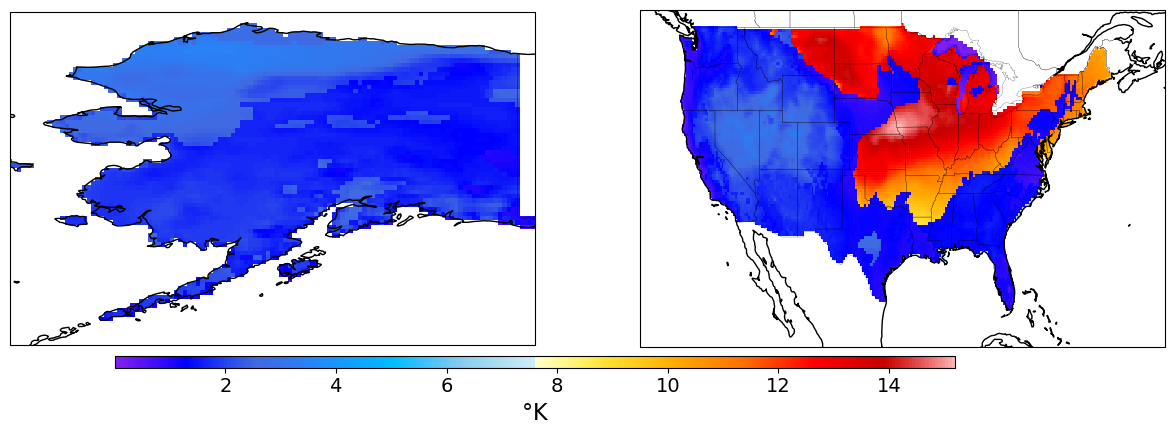

In [67]:
cmap=cmaps.ncl_default
proj=ccrs.PlateCarree()

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(14,6),subplot_kw={'projection':proj})
plt.subplots_adjust(bottom=0.15, right=0.95)
cc=jump.plot.pcolormesh(ax=ax[0],cmap=cmap,add_colorbar=False)
ax[0].set_extent([190,220,53,72],ccrs.PlateCarree())

cc=jump.plot.pcolormesh(ax=ax[1],cmap=cmap,add_colorbar=False)
ax[1].set_extent([230,300,22,50.5],ccrs.PlateCarree())


ax_cbar = fig.add_axes([0.2, 0.2, 0.6, 0.02])
cbar=fig.colorbar(cc,cax=ax_cbar,shrink=0.5,orientation='horizontal')
cbar.ax.tick_params(labelsize=14)  
cbar.set_label(label=f'{units}',fontsize=16)


asp = np.diff(ax[0].get_xlim())[0] / np.diff(ax[0].get_ylim())[0]
ax[1].set_aspect(asp)

for i in range(len(ax)):
  ax[i].add_feature(state_borders,zorder=100,edgecolor='k',linewidth=0.15)
  ax[i].coastlines()
  ax[i].set_title('')
plt.suptitle(f'',fontsize=20)  
#outfile=f'PLOTS/.png'
#plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

In [68]:
time[0:1026:12*4].dt.year.data

array([1940, 1944, 1948, 1952, 1956, 1960, 1964, 1968, 1972, 1976, 1980,
       1984, 1988, 1992, 1996, 2000, 2004, 2008, 2012, 2016, 2020, 2024])

Text(0.5, 0.98, '')

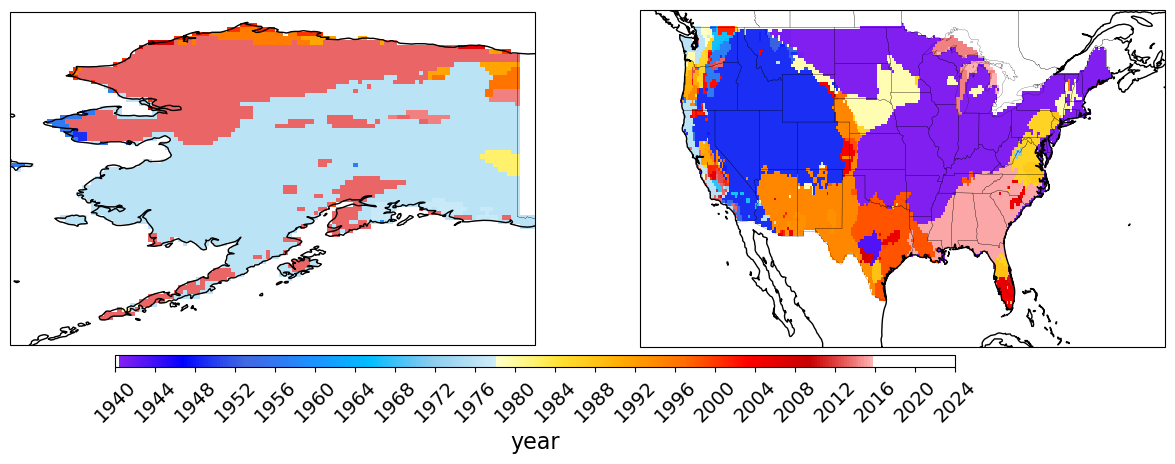

In [69]:
cmap=cmaps.ncl_default
proj=ccrs.PlateCarree()

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(14,6),subplot_kw={'projection':proj})
plt.subplots_adjust(bottom=0.15, right=0.95)
cc=time_jump.plot.pcolormesh(ax=ax[0],cmap=cmap,add_colorbar=False)
ax[0].set_extent([190,220,53,72],ccrs.PlateCarree())

cc=time_jump.plot.pcolormesh(ax=ax[1],cmap=cmap,add_colorbar=False)
ax[1].set_extent([230,300,22,50.5],ccrs.PlateCarree())


ax_cbar = fig.add_axes([0.2, 0.2, 0.6, 0.02])
cbar=fig.colorbar(cc,cax=ax_cbar,shrink=0.5,orientation='horizontal')
cbar.set_ticks(np.arange(0,1026,12*4))
cbar.set_ticklabels(time[0:1026:12*4].dt.year.data,rotation=45)
cbar.ax.tick_params(labelsize=14)  
cbar.set_label(label=f'year',fontsize=16)


asp = np.diff(ax[0].get_xlim())[0] / np.diff(ax[0].get_ylim())[0]
ax[1].set_aspect(asp)

for i in range(len(ax)):
  ax[i].add_feature(state_borders,zorder=100,edgecolor='k',linewidth=0.15)
  ax[i].coastlines()
  ax[i].set_title('')
plt.suptitle(f'',fontsize=20)  

In [82]:
ptlon=[211.25,210,213.5,200.75,269,274.5,245.25,255.75,236.5,236.5,261.75]
ptlat=[60.5,61.75,64.25,68.25,38.5,33,42.25,32.25,39.25,47.25,42 ]

Text(0.5, 0.98, '')

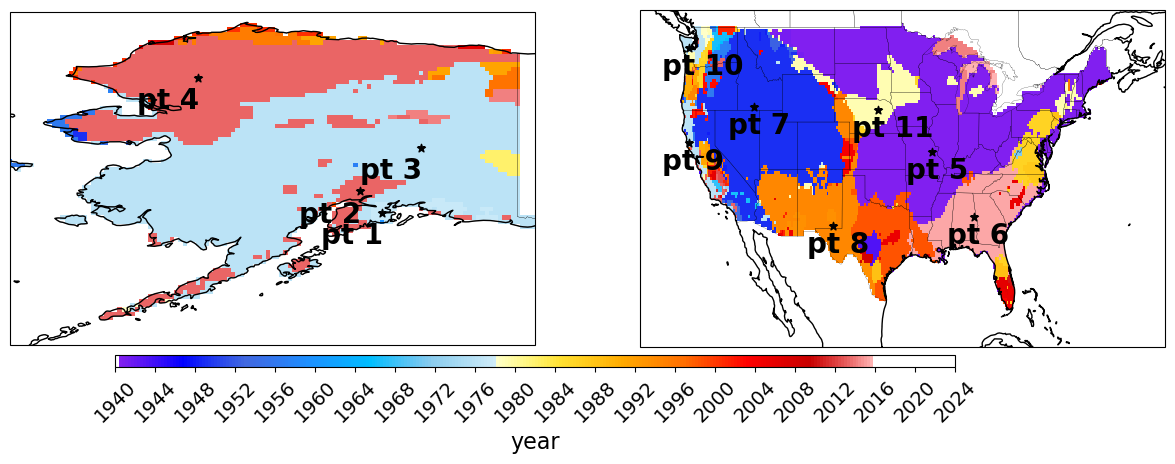

In [83]:
cmap=cmaps.ncl_default
proj=ccrs.PlateCarree()

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(14,6),subplot_kw={'projection':proj})
plt.subplots_adjust(bottom=0.15, right=0.95)
cc=time_jump.plot.pcolormesh(ax=ax[0],cmap=cmap,add_colorbar=False)
ax[0].set_extent([190,220,53,72],ccrs.PlateCarree())
for ip in range(0,4):
  ax[0].scatter(ptlon[ip],ptlat[ip],marker='*',color='k')
  ax[0].text(ptlon[ip]-360-3.5,ptlat[ip]-1.75,f'pt {ip+1}',color='k',size=20,weight='bold')

cc=time_jump.plot.pcolormesh(ax=ax[1],cmap=cmap,add_colorbar=False)
ax[1].set_extent([230,300,22,50.5],ccrs.PlateCarree())
for ip in range(4,len(ptlon)):
  ax[1].scatter(ptlon[ip],ptlat[ip],marker='*',color='k')
  ax[1].text(ptlon[ip]-360-3.5,ptlat[ip]-2.25,f'pt {ip+1}',color='k',size=20,weight='bold')


ax_cbar = fig.add_axes([0.2, 0.2, 0.6, 0.02])
cbar=fig.colorbar(cc,cax=ax_cbar,shrink=0.5,orientation='horizontal')
cbar.set_ticks(np.arange(0,1026,12*4))
cbar.set_ticklabels(time[0:1026:12*4].dt.year.data,rotation=45)
cbar.ax.tick_params(labelsize=14)  
cbar.set_label(label=f'year',fontsize=16)


asp = np.diff(ax[0].get_xlim())[0] / np.diff(ax[0].get_ylim())[0]
ax[1].set_aspect(asp)

for i in range(len(ax)):
  ax[i].add_feature(state_borders,zorder=100,edgecolor='k',linewidth=0.15)
  ax[i].coastlines()
  ax[i].set_title('')
plt.suptitle(f'',fontsize=20)  

In [84]:
import ruptures as rpt

<>:17: SyntaxWarning: invalid escape sequence '\d'
<>:17: SyntaxWarning: invalid escape sequence '\d'
<>:17: SyntaxWarning: invalid escape sequence '\d'
<>:17: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_1503769/1113330443.py:17: SyntaxWarning: invalid escape sequence '\d'
  plt.title(f'Point {ij+1} ({lonij:0.1f}$\degree$,{latij:0.1f}$\degree$)'\
/tmp/ipykernel_1503769/1113330443.py:17: SyntaxWarning: invalid escape sequence '\d'
  plt.title(f'Point {ij+1} ({lonij:0.1f}$\degree$,{latij:0.1f}$\degree$)'\


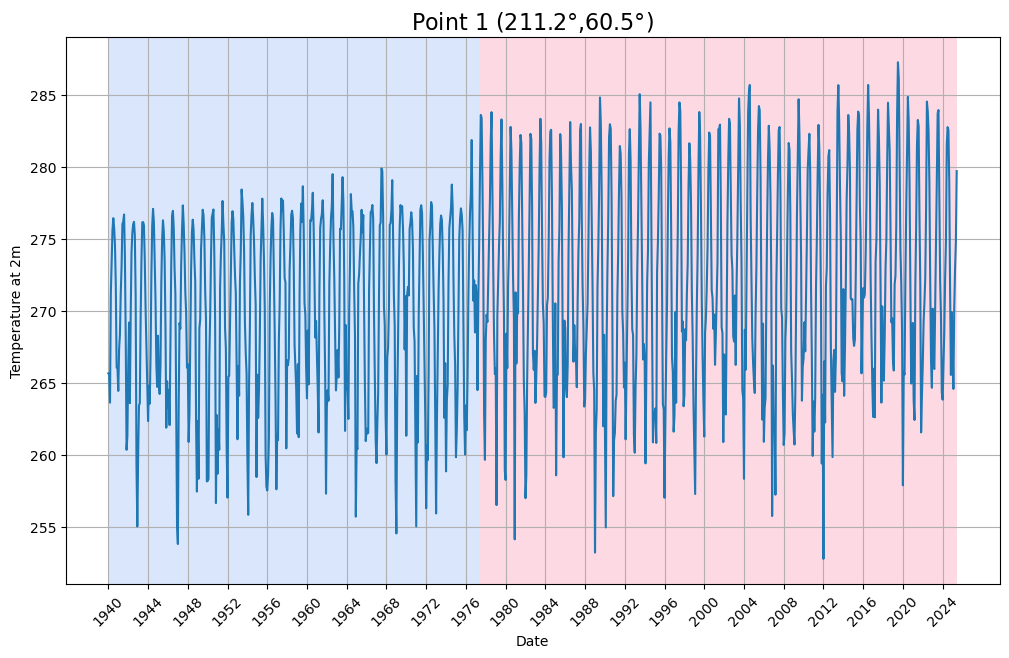

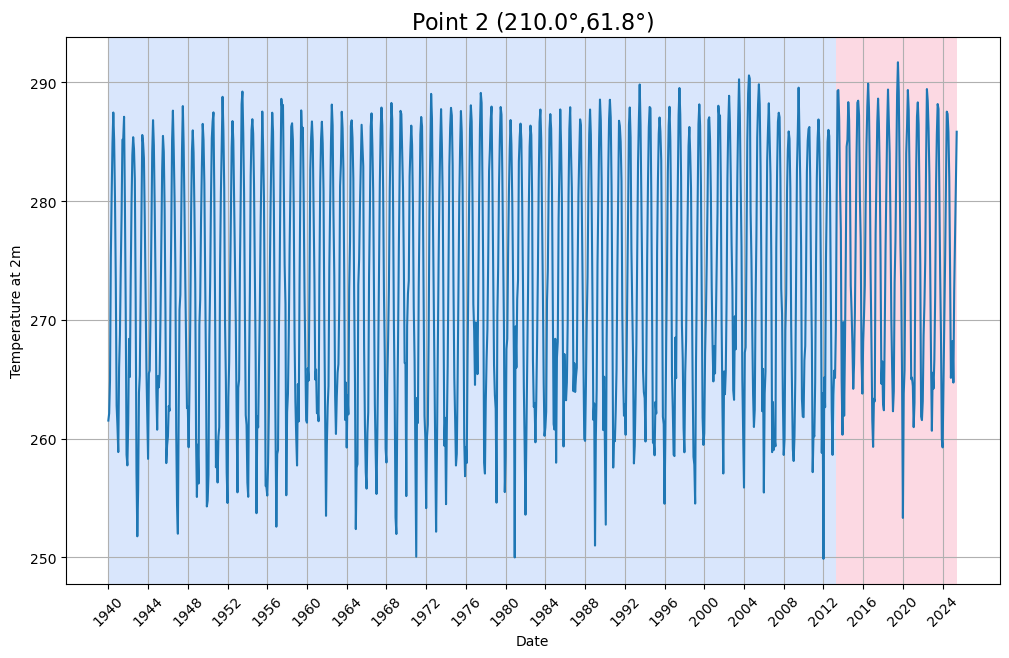

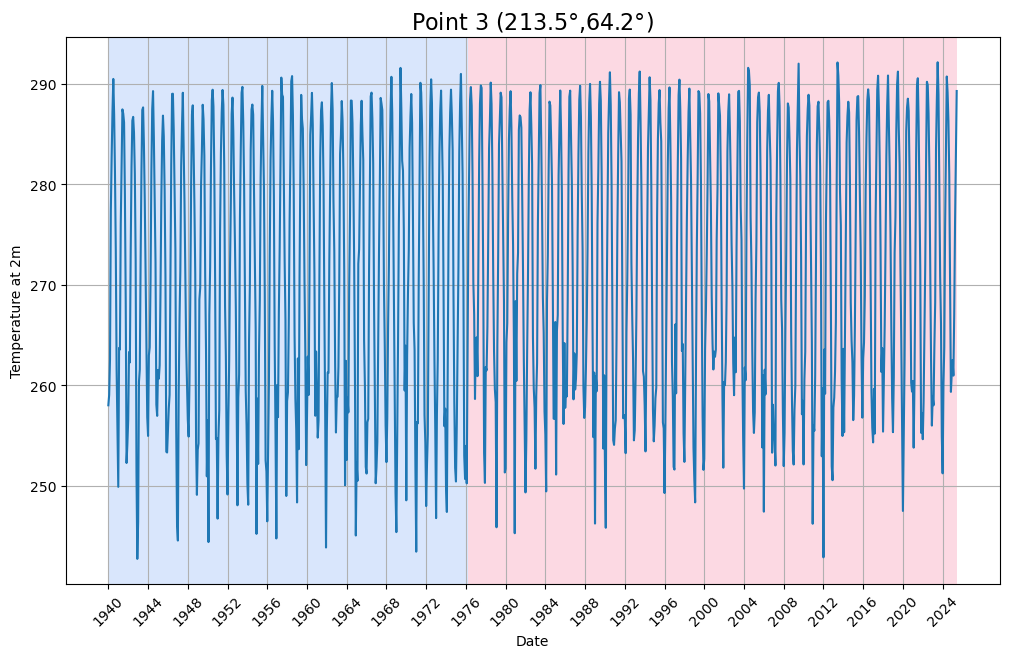

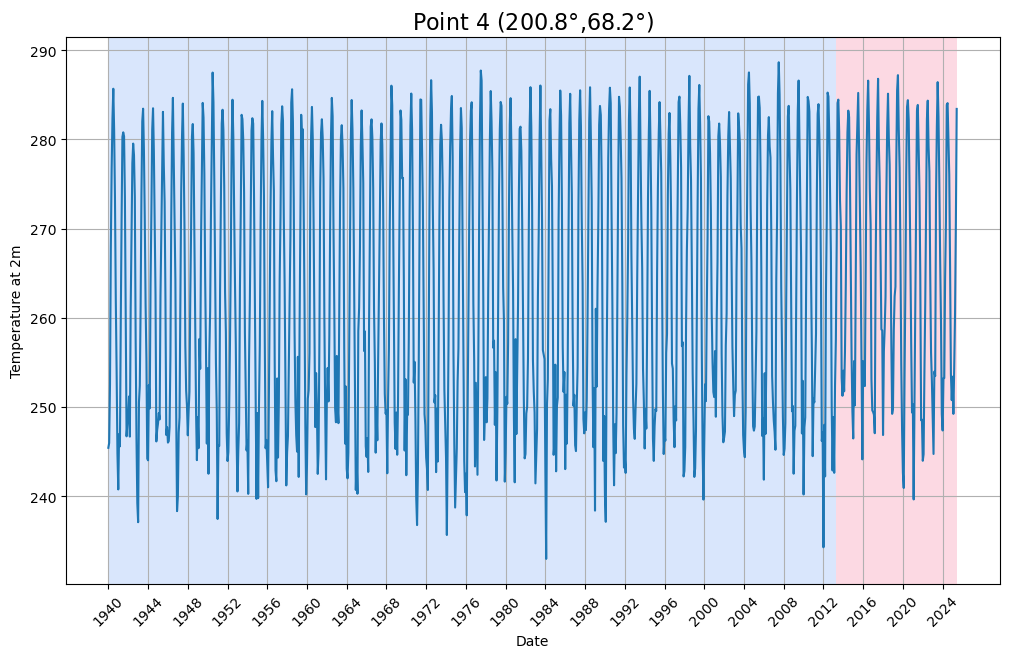

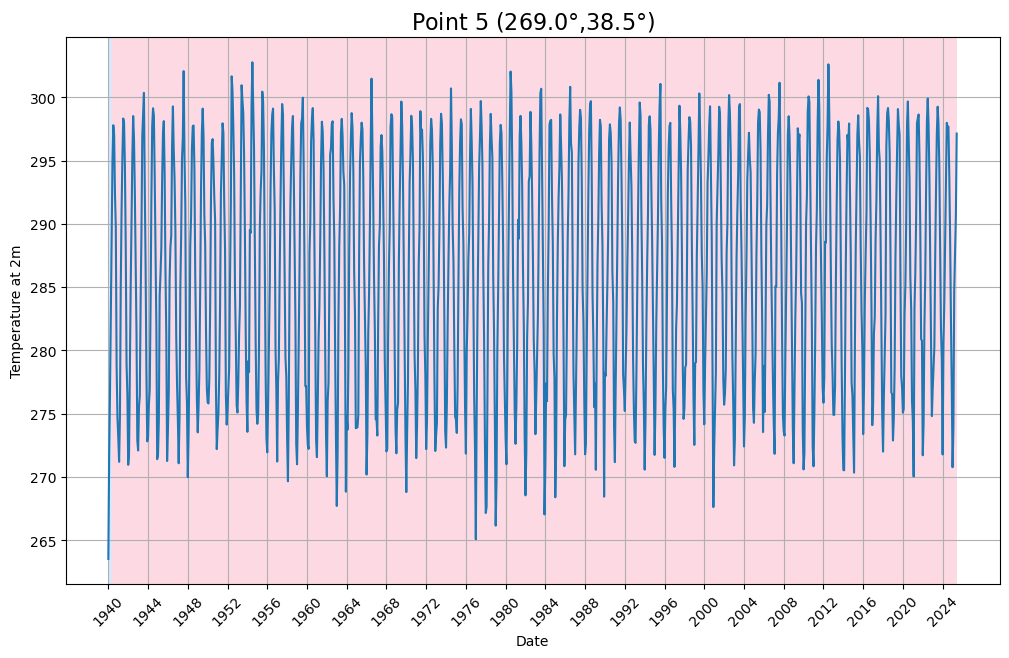

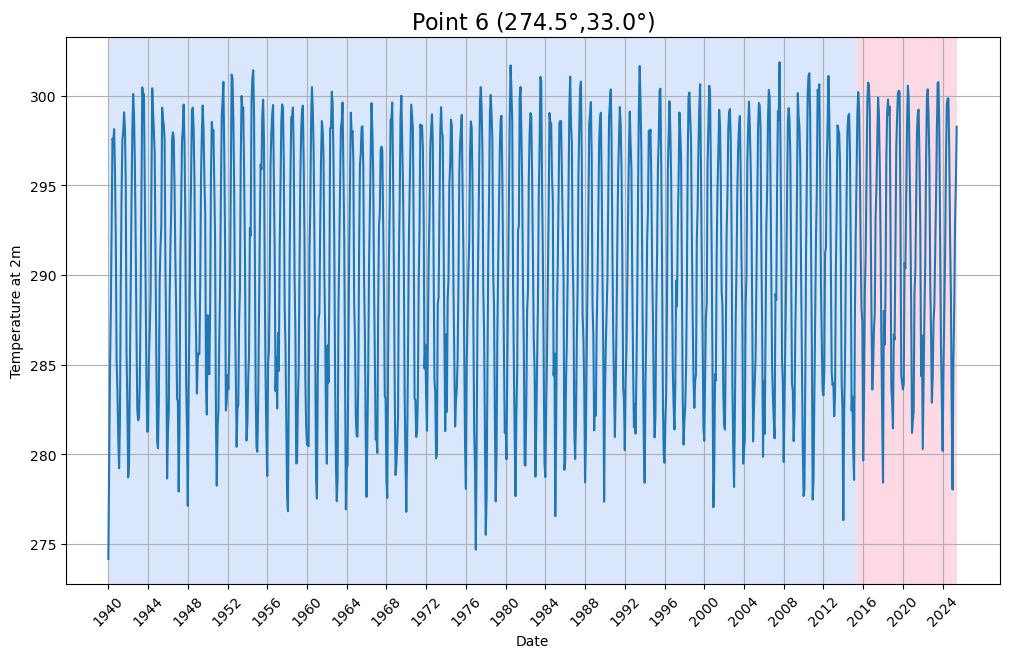

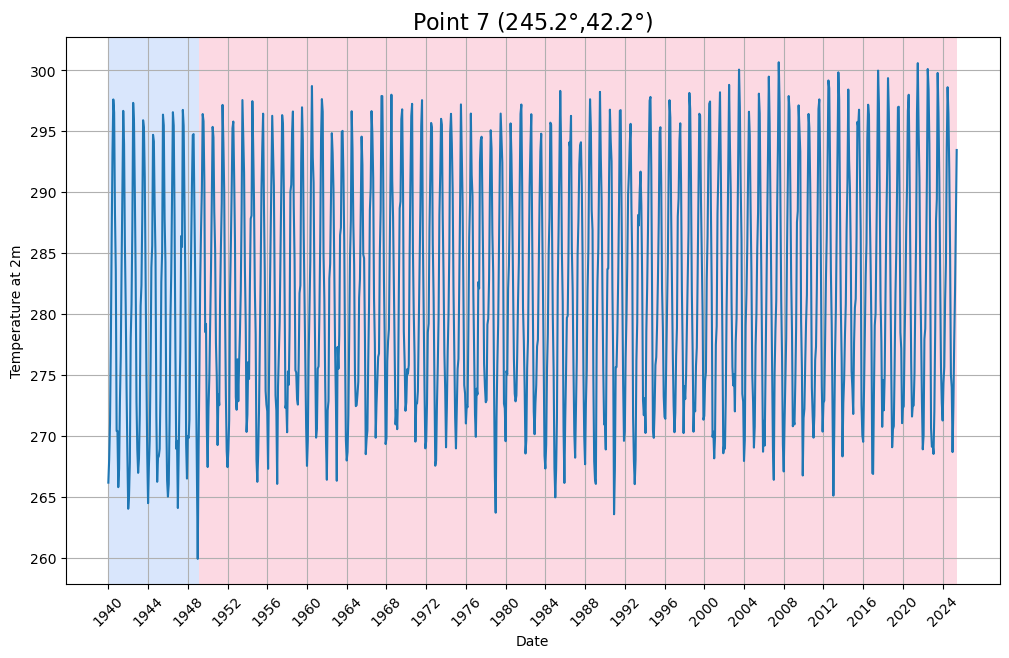

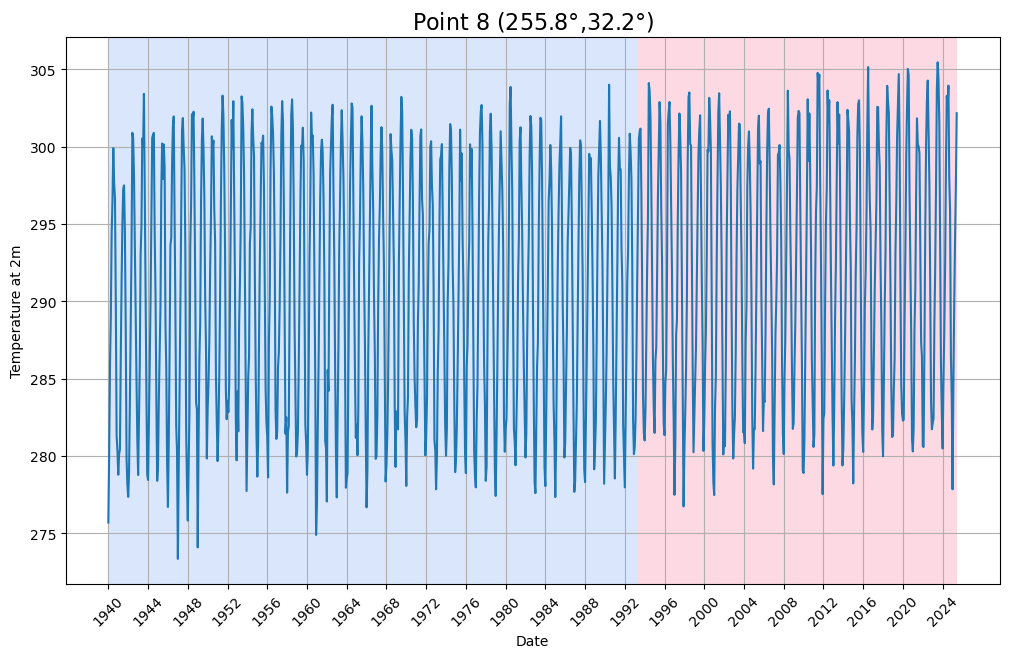

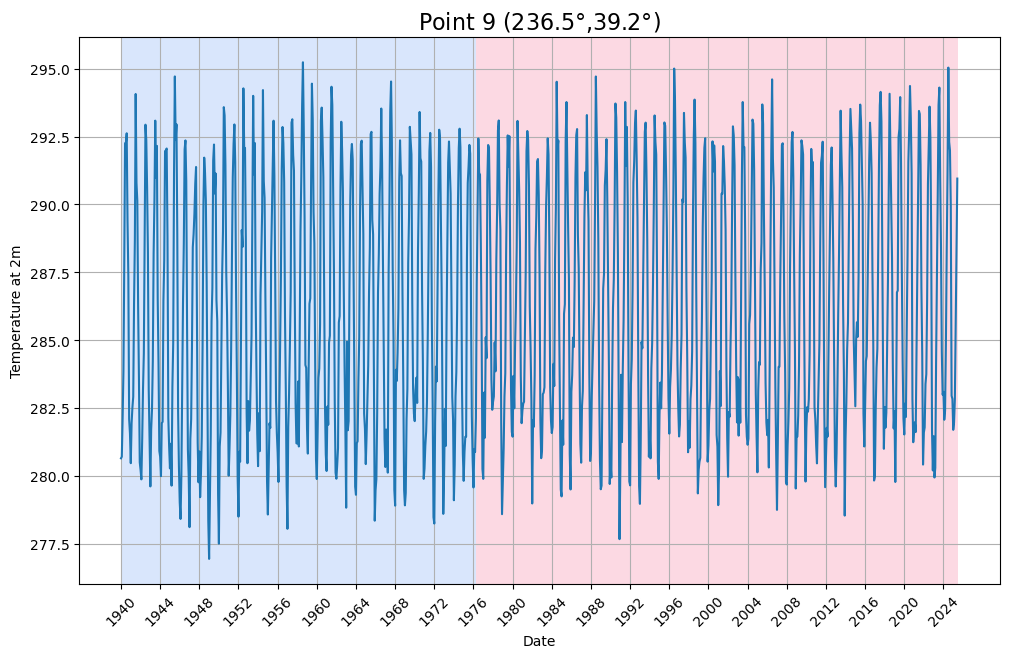

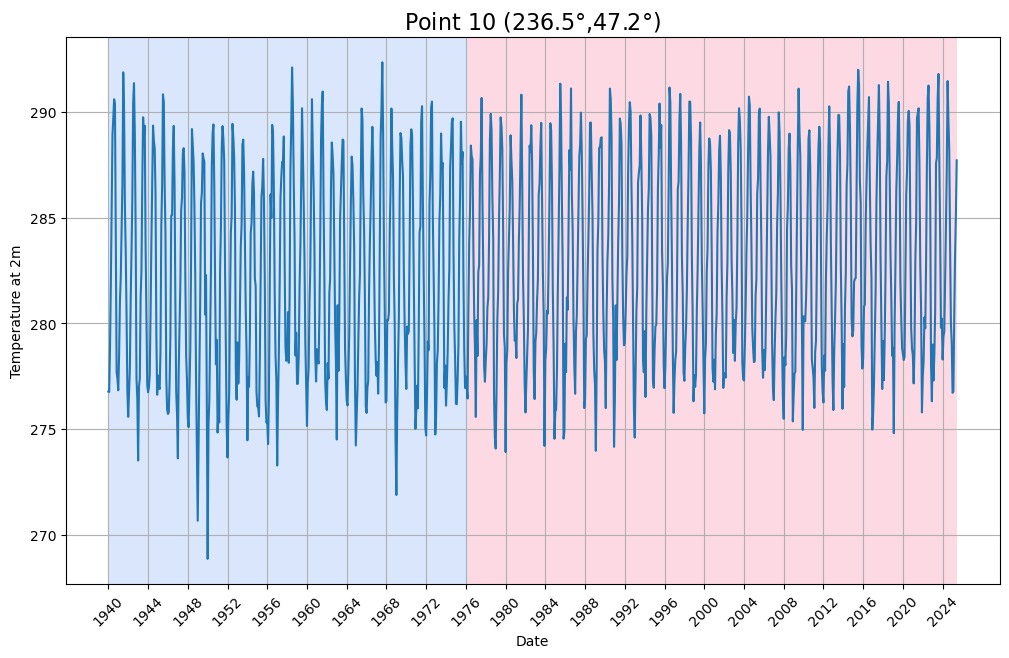

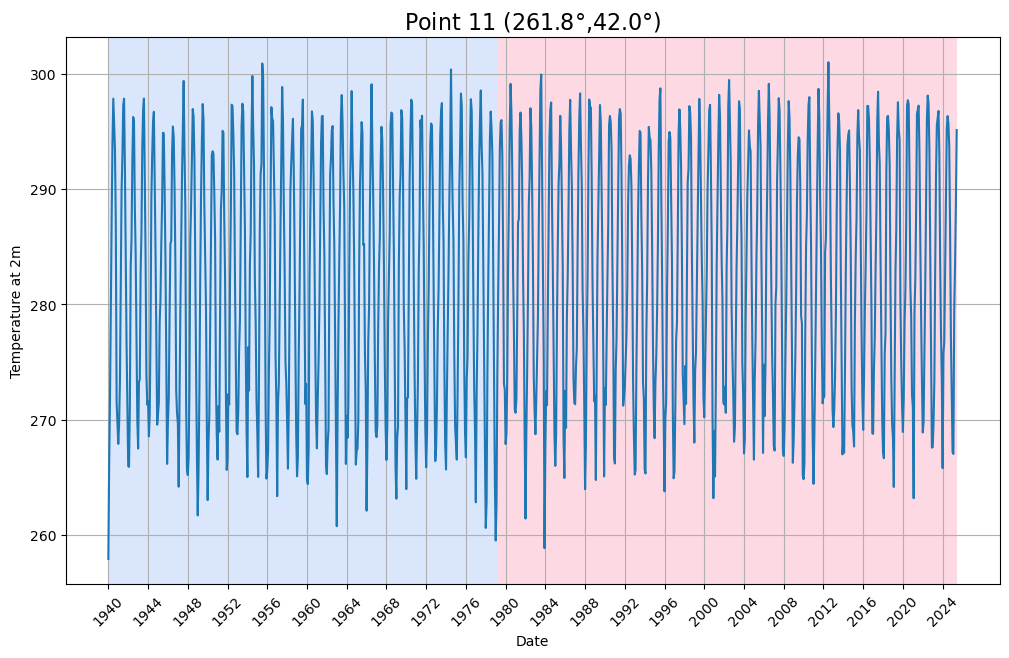

In [85]:
model = "rbf"  # "l1", "rbf", "linear", "normal", "ar",...
n=len(dsair['time'])
for ij in range(0,len(ptlon)):
  latij=ptlat[ij]
  lonij=ptlon[ij]
  airij = dsair['air'].sel(lon = lonij,lat= latij)
  #
  algo = rpt.Binseg(model=model).fit(airij.data.reshape(-1, 1))
  my_bkps = algo.predict(n_bkps=1)
  #
  # Visualize data:
  fig, axarr =rpt.display(airij.data.reshape(-1, 1), my_bkps, figsize=(10, 6))
  plt.xlabel('Date') 
  plt.ylabel('Temperature at 2m') 
  plt.xticks(ticks=range(0, len(time),12*4), labels=time[0:1026:12*4].dt.year.data,rotation=45) 
  plt.grid(True)
  plt.title(f'Point {ij+1} ({lonij:0.1f}$\degree$,{latij:0.1f}$\degree$)'\
    ,fontsize=16)
  plt.show()